# Fine-tuning YOLOv8 on ImageNet (15 Categories)

## Objectif
Ce notebook effectue le fine-tuning du modèle YOLOv8n pré-entraîné sur un sous-ensemble de 15 catégories ImageNet pour améliorer la détection d'objets pour les 15 categories.

## Contenu
- Chargement et préparation des données ImageNet
- Configuration du modèle YOLOv8n
- Entraînement et validation
- Évaluation des performances

Preparation de l'environnement

# Description
Monter Google Drive dans Colab pour accéder aux fichiers.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive



### Décompresse l'archive du projet depuis Google Drive dans /content.

In [2]:
!unzip -q "/content/drive/MyDrive/mini projet 1.zip" -d /content



### Installer les dépendances Python nécessaires (ultralytics, OpenCV, etc.).

In [3]:
!pip install ultralytics opencv-python scikit-image pandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:00


### Installer PyPI packages requis (ultralytics, opencv-python, scikit-image, pandas, matplotlib).

In [4]:
from ultralytics import YOLO
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random, os


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.



### Importer les bibliothèques Python nécessaires (YOLO, cv2, numpy, pandas, matplotlib, etc.).

In [5]:
from pathlib import Path

ROOT = Path("/content/mini projet 1")   # attention à l’espace dans le nom
DATA_ROOT = ROOT / "DATA"
YOLO_DATASET = DATA_ROOT / "dataset_yolo"
yaml_path = YOLO_DATASET / "dataset_yolo.yaml"

print("ROOT        :", ROOT, ROOT.exists())
print("DATA_ROOT   :", DATA_ROOT, DATA_ROOT.exists())
print("YOLO_DATASET:", YOLO_DATASET, YOLO_DATASET.exists())


ROOT        : /content/mini projet 1 True
DATA_ROOT   : /content/mini projet 1/DATA True
YOLO_DATASET: /content/mini projet 1/DATA/dataset_yolo True



### Définir les chemins du projet (ROOT, DATA_ROOT, YOLO_DATASET) et vérifier leur existence.

In [6]:
train_imgs = list((YOLO_DATASET / "images" / "train").glob("*.*"))
val_imgs   = list((YOLO_DATASET / "images" / "val").glob("*.*"))
train_lbls = list((YOLO_DATASET / "labels" / "train").glob("*.txt"))
val_lbls   = list((YOLO_DATASET / "labels" / "val").glob("*.txt"))

print("Nb images train :", len(train_imgs))
print("Nb labels train :", len(train_lbls))
print("Nb images val   :", len(val_imgs))
print("Nb labels val   :", len(val_lbls))


Nb images train : 11504
Nb labels train : 11504
Nb images val   : 2862
Nb labels val   : 2862



### Lister les images et labels d'entraînement/validation et afficher leurs quantités.

Label choisi : n03790512_4464.txt
11 0.19884923100471497 0.515399158000946 0.39769846200942993 0.40334588289260864
10 0.5384672284126282 0.26658952236175537 0.06574071198701859 0.027747437357902527
10 0.478285014629364 0.25659865140914917 0.041849058121442795 0.018576156347990036
10 0.2942524254322052 0.305581659078598 0.170696422457695 0.10731181502342224
11 0.1690521240234375 0.7198033332824707 0.338104248046875 0.3563839793205261
10 0.20093949139118195 0.33175158500671387 0.27436187863349915 0.09830059856176376
10 0.26007136702537537 0.3292289972305298 0.16204437613487244 0.09834194928407669
Image associée : /content/mini projet 1/DATA/dataset_yolo/images/train/n03790512_4464.JPEG True


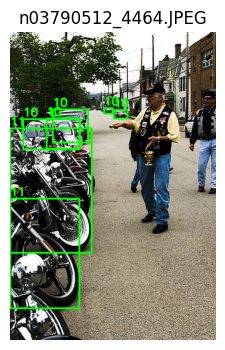

In [7]:
def show_yolo_bbox(img_path, label_path):
    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]

    lines = label_path.read_text().strip().splitlines()
    boxes = []
    for line in lines:
        parts = line.split()
        if len(parts) != 5:
            continue
        cid, xc, yc, bw, bh = map(float, parts)
        xc *= w; yc *= h; bw *= w; bh *= h
        x1 = int(xc - bw/2); y1 = int(yc - bh/2)
        x2 = int(xc + bw/2); y2 = int(yc + bh/2)
        boxes.append((int(cid), x1, y1, x2, y2))

    img_vis = img.copy()
    for cid, x1, y1, x2, y2 in boxes:
        cv2.rectangle(img_vis, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(img_vis, str(cid), (x1, max(0,y1-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    plt.figure(figsize=(4,4))
    plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(img_path.name)
    plt.show()

sample_label = random.choice(train_lbls)
print("Label choisi :", sample_label.name)
print(sample_label.read_text())

stem = sample_label.stem
img_path = None
for ext in [".JPEG", ".jpg", ".JPG", ".png"]:
    candidate = YOLO_DATASET / "images" / "train" / f"{stem}{ext}"
    if candidate.exists():
        img_path = candidate
        break

print("Image associée :", img_path, img_path.exists() if img_path else False)

if img_path is not None and img_path.exists():
    show_yolo_bbox(img_path, sample_label)
else:
    print("⚠️ image correspondante introuvable, vérifier les extensions.")



### Définir la fonction `show_yolo_bbox` pour afficher les bounding boxes YOLO et afficher un exemple aléatoire.

In [8]:
yaml_path = YOLO_DATASET / "dataset_yolo.yaml"

yaml_content = f"""
path: {YOLO_DATASET.as_posix()}
train: images/train
val: images/val

names:
  0: dog
  1: cat
  2: horse
  3: sheep
  4: bird
  5: chair
  6: bottle
  7: ball
  8: umbrella
  9: fork
  10: car
  11: motorcycle
  12: airplane
  13: bicycle
  14: boat
"""

yaml_path.write_text(yaml_content)
print(yaml_path.read_text())



path: /content/mini projet 1/DATA/dataset_yolo
train: images/train
val: images/val

names:
  0: dog
  1: cat
  2: horse
  3: sheep
  4: bird
  5: chair
  6: bottle
  7: ball
  8: umbrella
  9: fork
  10: car
  11: motorcycle
  12: airplane
  13: bicycle
  14: boat




### Créer et sauvegarder le fichier YAML de configuration du dataset (chemins et noms de classes).

In [9]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121



### Installer PyTorch (tailored pour CUDA 12.1 si disponible).

In [10]:
from ultralytics import YOLO

base_model_path = ROOT / "yolov8n.pt"
model = YOLO(str(base_model_path))

results = model.train(
    data=str(yaml_path),
    imgsz=640,
    epochs=30,              # 30 suffisent dans ton cas
    batch=16,
    device=0,               # GPU (quand tu y as accès)
    patience=10,            # early stopping si ça stagne
    cos_lr=True,
    workers=2,
    project="/content/drive/MyDrive/yolo_runs",
    name="imagenet15_yolov8n"   # nom du run dans ton Drive
)

print("Dossier d'entraînement :", results.save_dir)


Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/mini projet 1/DATA/dataset_yolo/dataset_yolo.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/mini projet 1/yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=imagenet15_yolov8n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overla


### Charger le modèle de base et lancer l'entraînement avec paramètres (imgsz, epochs, batch, device, etc.).

In [12]:
from pathlib import Path
from ultralytics import YOLO

# Tu peux soit réutiliser 'results.save_dir', soit écrire le chemin à la main :
finetuned_dir = Path("/content/drive/MyDrive/yolo_runs/imagenet15_yolov8n")

finetuned_weights = finetuned_dir / "weights" / "best.pt"

print("Poids finetunés :", finetuned_weights, finetuned_weights.exists())

model_ft = YOLO(str(finetuned_weights))  # charge ton modèle fine-tuné


Poids finetunés : /content/drive/MyDrive/yolo_runs/imagenet15_yolov8n/weights/best.pt True



### Charger les poids fine-tunés depuis le dossier du run et instancier `model_ft`.

In [13]:
from google.colab import files

files.download("/content/drive/MyDrive/yolo_runs/imagenet15_yolov8n/weights/best.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


### Télécharger le fichier de poids `best.pt` depuis Google Drive vers la machine locale (navigateur).

In [15]:
import shutil

shutil.copy2(
    "/content/drive/MyDrive/yolo_runs/imagenet15_yolov8n/weights/best.pt",
    "/content/yolov8n_imagenet15.pt"
)

print("Modèle enregistré :", "/content/yolov8n_imagenet15.pt")


Modèle enregistré : /content/yolov8n_imagenet15.pt



### Copier les poids `best.pt` dans `/content` pour un usage local.

In [16]:
from ultralytics import YOLO

model_ft = YOLO("/content/drive/MyDrive/yolo_runs/imagenet15_yolov8n/weights/best.pt")



### Charger le modèle fine-tuné depuis le chemin Drive pour l'inférence/évaluation.

In [17]:
metrics = model_ft.val(
    data=str(yaml_path),
    imgsz=640,
    device=0
)
metrics


Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2336.6±911.1 MB/s, size: 138.8 KB)
val: Scanning /content/mini projet 1/DATA/dataset_yolo/labels/val.cache... 2862 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2862/2862 3.7Mit/s 0.0s
val: /content/mini projet 1/DATA/dataset_yolo/images/val/n02374451_16145.JPEG: corrupt JPEG restored and saved
val: /content/mini projet 1/DATA/dataset_yolo/images/val/n02691156_7953.JPEG: corrupt JPEG restored and saved
val: /content/mini projet 1/DATA/dataset_yolo/images/val/n02834778_86.JPEG: corrupt JPEG restored and saved
val: /content/mini projet 1/DATA/dataset_yolo/images/val/n02876657_5671.JPEG: corrupt JPEG restored and saved
val: /content/mini projet 1/DATA/dataset_yolo/images/val/n02958343_11864.JPEG: corrupt JPEG restored and saved
val: /content/mini projet 1/DATA/dataset_yolo/

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e5e14c721e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.0


 ### Calculer les métriques de validation (mAP) du modèle fine-tuné.

In [18]:
try:
    print("mAP50 global   :", metrics.box.map50)
    print("mAP50-95 global:", metrics.box.map)
except Exception as e:
    print("Impossible de lire metrics.box :", e)


mAP50 global   : 0.8297176609432716
mAP50-95 global: 0.7278265304494116



### Afficher les métriques principales (mAP50 et mAP50-95) si disponibles.

In [19]:
class_names = [
    "dog","cat","horse","sheep","bird",
    "chair","bottle","ball","umbrella","fork",
    "car","motorcycle","airplane","bicycle","boat"
]

try:
    maps = list(metrics.box.maps)   # 1 valeur par classe
    df_cls = pd.DataFrame({
        "class_id": range(len(class_names)),
        "class_name": class_names,
        "mAP": maps
    })
    display(df_cls)
except Exception as e:
    print("Impossible de récupérer maps par classe :", e)


class_id  class_name       mAP
0          0         dog  0.766186
1          1         cat  0.843532
2          2       horse  0.825258
3          3       sheep  0.794934
4          4        bird  0.789404
5          5       chair  0.658230
6          6      bottle  0.792246
7          7        ball  0.720225
8          8    umbrella  0.815213
9          9        fork  0.727827
10        10         car  0.809975
11        11  motorcycle  0.757649
12        12    airplane  0.840777
13        13     bicycle  0.760402
14        14        boat  0.015540


### Construire un DataFrame des mAP par classe et l'afficher.

In [20]:
print("Dossier résultats :", finetuned_dir)
!ls "{finetuned_dir}"


Dossier résultats : /content/drive/MyDrive/yolo_runs/imagenet15_yolov8n
args.yaml			 results.csv	       val_batch0_labels.jpg
BoxF1_curve.png			 results.png	       val_batch0_pred.jpg
BoxP_curve.png			 train_batch0.jpg      val_batch1_labels.jpg
BoxPR_curve.png			 train_batch14380.jpg  val_batch1_pred.jpg
BoxR_curve.png			 train_batch14381.jpg  val_batch2_labels.jpg
confusion_matrix_normalized.png  train_batch14382.jpg  val_batch2_pred.jpg
confusion_matrix.png		 train_batch1.jpg      weights
labels.jpg			 train_batch2.jpg



### Lister et afficher le contenu du dossier du run (finetuned_dir).

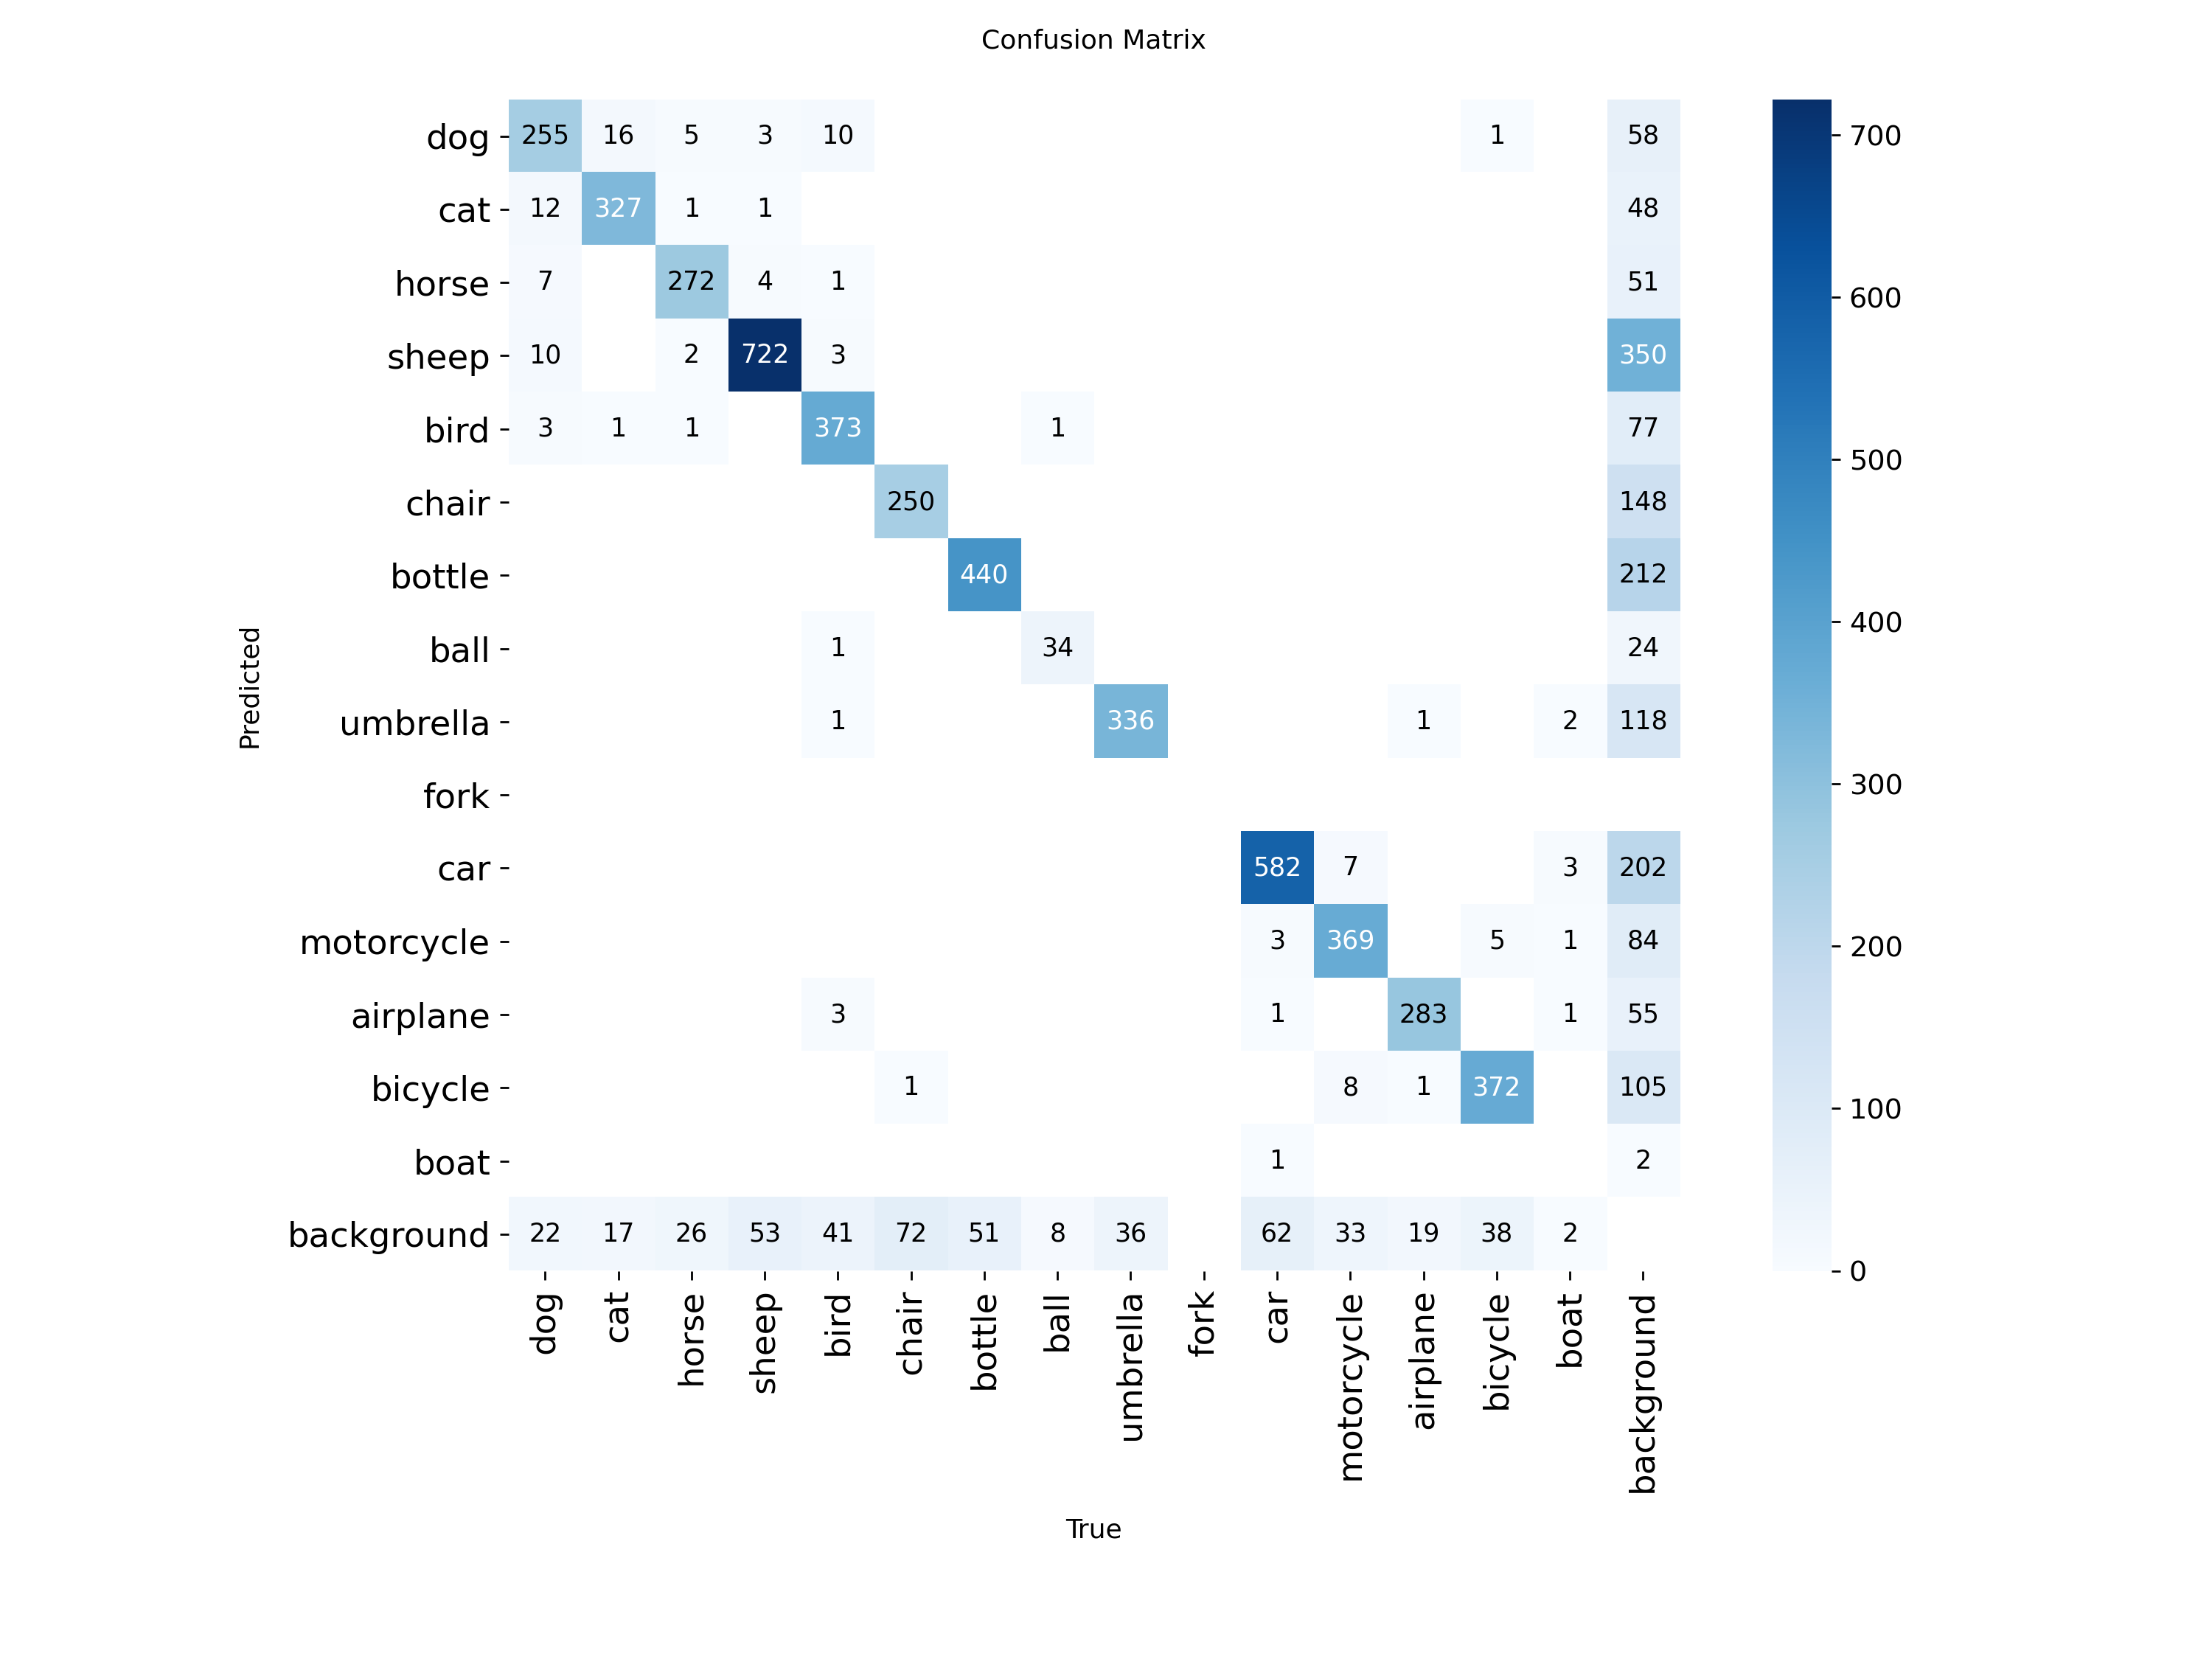

In [21]:
from IPython.display import Image, display

# Courbes PR, F1, etc. si disponibles
for fname in ["PR_curve.png", "F1_curve.png", "confusion_matrix.png"]:
    f = finetuned_dir / fname
    if f.exists():
        display(Image(filename=str(f)))



### Afficher les images de diagnostic (PR_curve, F1_curve, confusion_matrix) si elles existent dans le run.

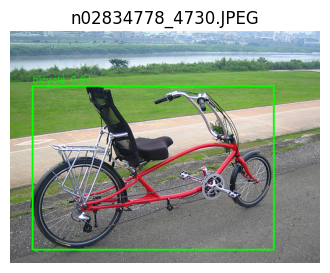

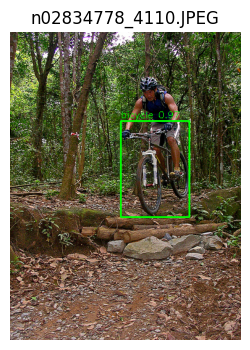

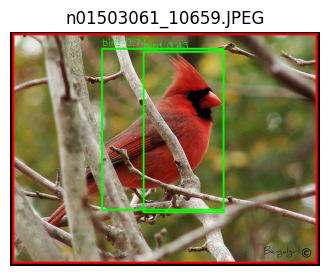

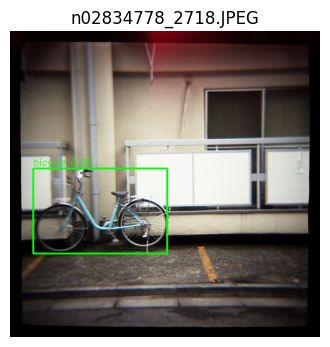

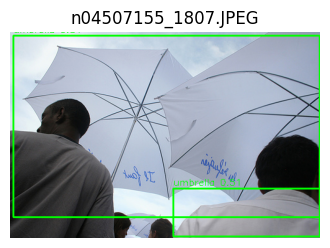

In [22]:
def visualize_predictions(model, img_paths, class_names, conf=0.4):
    for img_path in img_paths:
        img = cv2.imread(str(img_path))
        results = model(img, conf=conf, verbose=False)[0]

        img_vis = img.copy()
        for box in results.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
            cid = int(box.cls[0])
            score = float(box.conf[0])

            if cid < 0 or cid >= len(class_names):
                continue

            label = f"{class_names[cid]} {score:.2f}"
            cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(img_vis, label, (x1, max(0, y1-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

        plt.figure(figsize=(4,4))
        plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(img_path.name)
        plt.show()

val_imgs = list((YOLO_DATASET / "images" / "val").glob("*.*"))
sample_val_imgs = random.sample(val_imgs, min(5, len(val_imgs)))

visualize_predictions(model_ft, sample_val_imgs, class_names, conf=0.4)



### Définir `visualize_predictions` pour dessiner les boxes et labels sur les images, puis afficher des échantillons de validation.

In [27]:
from google.colab import files
uploaded = files.upload()  # choisis une image .jpg / .png


Saving test1.png to test1 (1).png



### Uploader une image depuis l'ordinateur (interface Colab) pour la tester avec le modèle.

Test image : test bottle.jpg


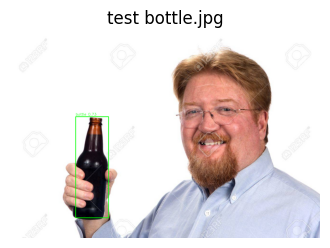

In [28]:
test_img_path = list(Path(".").glob("*.jpg"))[0]  # ou adapte le nom
print("Test image :", test_img_path)

visualize_predictions(model_ft, [test_img_path], class_names, conf=0.4)



### Sélectionner une image test locale et afficher ses prédictions avec `visualize_predictions`.

In [29]:
from google.colab import drive
drive.mount('/content/drive')

save_path = Path("/content/drive/MyDrive/yolo_15classes_best.pt")
shutil.copy2(finetuned_weights, save_path)
print("Modèle sauvegardé dans :", save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modèle sauvegardé dans : /content/drive/MyDrive/yolo_15classes_best.pt



### Monter Google Drive (si non monté) puis sauvegarder une copie du modèle dans Drive.

In [30]:
import torch
import pandas as pd

device = 0 if torch.cuda.is_available() else "cpu"
print("Device utilisé pour la validation :", device)

metrics = model_ft.val(
    data=str(yaml_path),
    imgsz=640,
    device=device
)

print("mAP50 global   :", metrics.box.map50)
print("mAP50-95 global:", metrics.box.map)

# Noms de classes (adapter si tu en as changé)
class_names = [
    "dog","cat","horse","sheep","bird",
    "chair","bottle","ball","umbrella","fork",
    "car","motorcycle","airplane","bicycle","boat"
]

# mAP par classe
maps = list(metrics.box.maps)  # len = nb_classes

df_metrics = pd.DataFrame({
    "id": list(range(len(class_names))),
    "classe": class_names,
    "mAP_50_95": maps
}).sort_values("mAP_50_95", ascending=False)

df_metrics


Device utilisé pour la validation : 0
Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 856.8±501.5 MB/s, size: 50.3 KB)
val: Scanning /content/mini projet 1/DATA/dataset_yolo/labels/val.cache... 2862 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2862/2862 6.0Mit/s 0.0s
val: /content/mini projet 1/DATA/dataset_yolo/images/val/n02374451_16145.JPEG: corrupt JPEG restored and saved
val: /content/mini projet 1/DATA/dataset_yolo/images/val/n02691156_7953.JPEG: corrupt JPEG restored and saved
val: /content/mini projet 1/DATA/dataset_yolo/images/val/n02834778_86.JPEG: corrupt JPEG restored and saved
val: /content/mini projet 1/DATA/dataset_yolo/images/val/n02876657_5671.JPEG: corrupt JPEG restored and saved
val: /content/mini projet 1/DATA/dataset_yolo/images/val/n02958343_11864.JPEG: corrupt JPEG restored and saved
val: /content/mini projet 1/DATA/dataset_yolo/images/val/n02958343_4720.JPEG: corrupt JPEG

id      classe  mAP_50_95
1    1         cat   0.843532
12  12    airplane   0.840777
2    2       horse   0.825258
8    8    umbrella   0.815213
10  10         car   0.809975
3    3       sheep   0.794934
6    6      bottle   0.792246
4    4        bird   0.789404
0    0         dog   0.766186
13  13     bicycle   0.760402
11  11  motorcycle   0.757649
9    9        fork   0.727827
7    7        ball   0.720225
5    5       chair   0.658230
14  14        boat   0.015540


### Déterminer le device (GPU/CPU), valider le modèle et construire un DataFrame des mAP par classe.

Dossier du run : /content/drive/MyDrive/yolo_runs/imagenet15_yolov8n
args.yaml			 results.csv	       val_batch0_labels.jpg
BoxF1_curve.png			 results.png	       val_batch0_pred.jpg
BoxP_curve.png			 train_batch0.jpg      val_batch1_labels.jpg
BoxPR_curve.png			 train_batch14380.jpg  val_batch1_pred.jpg
BoxR_curve.png			 train_batch14381.jpg  val_batch2_labels.jpg
confusion_matrix_normalized.png  train_batch14382.jpg  val_batch2_pred.jpg
confusion_matrix.png		 train_batch1.jpg      weights
labels.jpg			 train_batch2.jpg

==> results.png


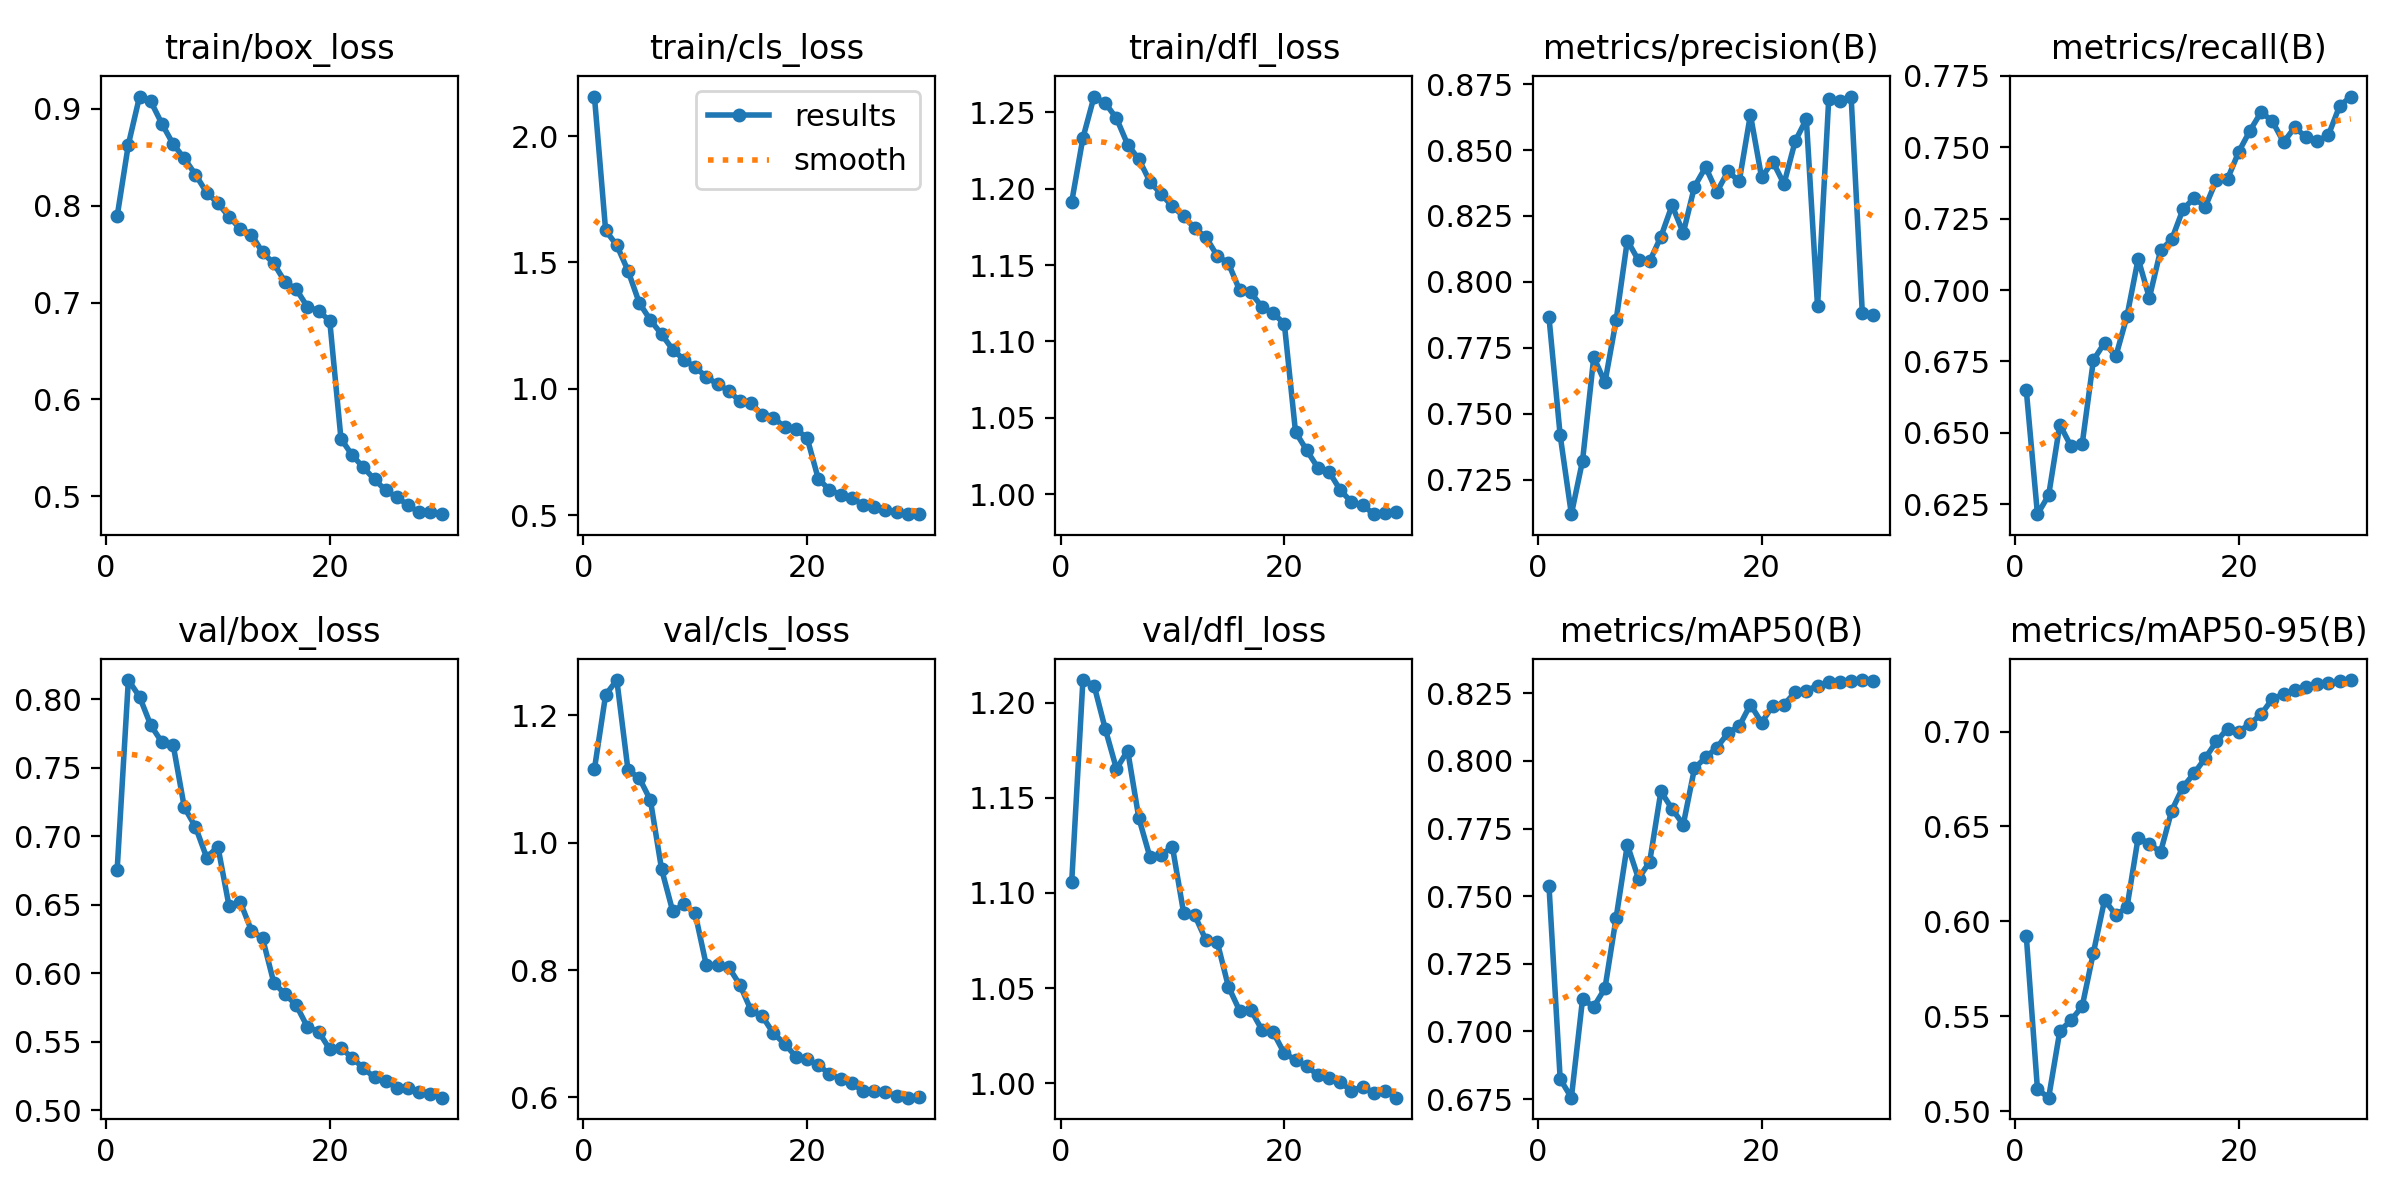

PR_curve.png n'existe pas dans /content/drive/MyDrive/yolo_runs/imagenet15_yolov8n
F1_curve.png n'existe pas dans /content/drive/MyDrive/yolo_runs/imagenet15_yolov8n

==> confusion_matrix.png


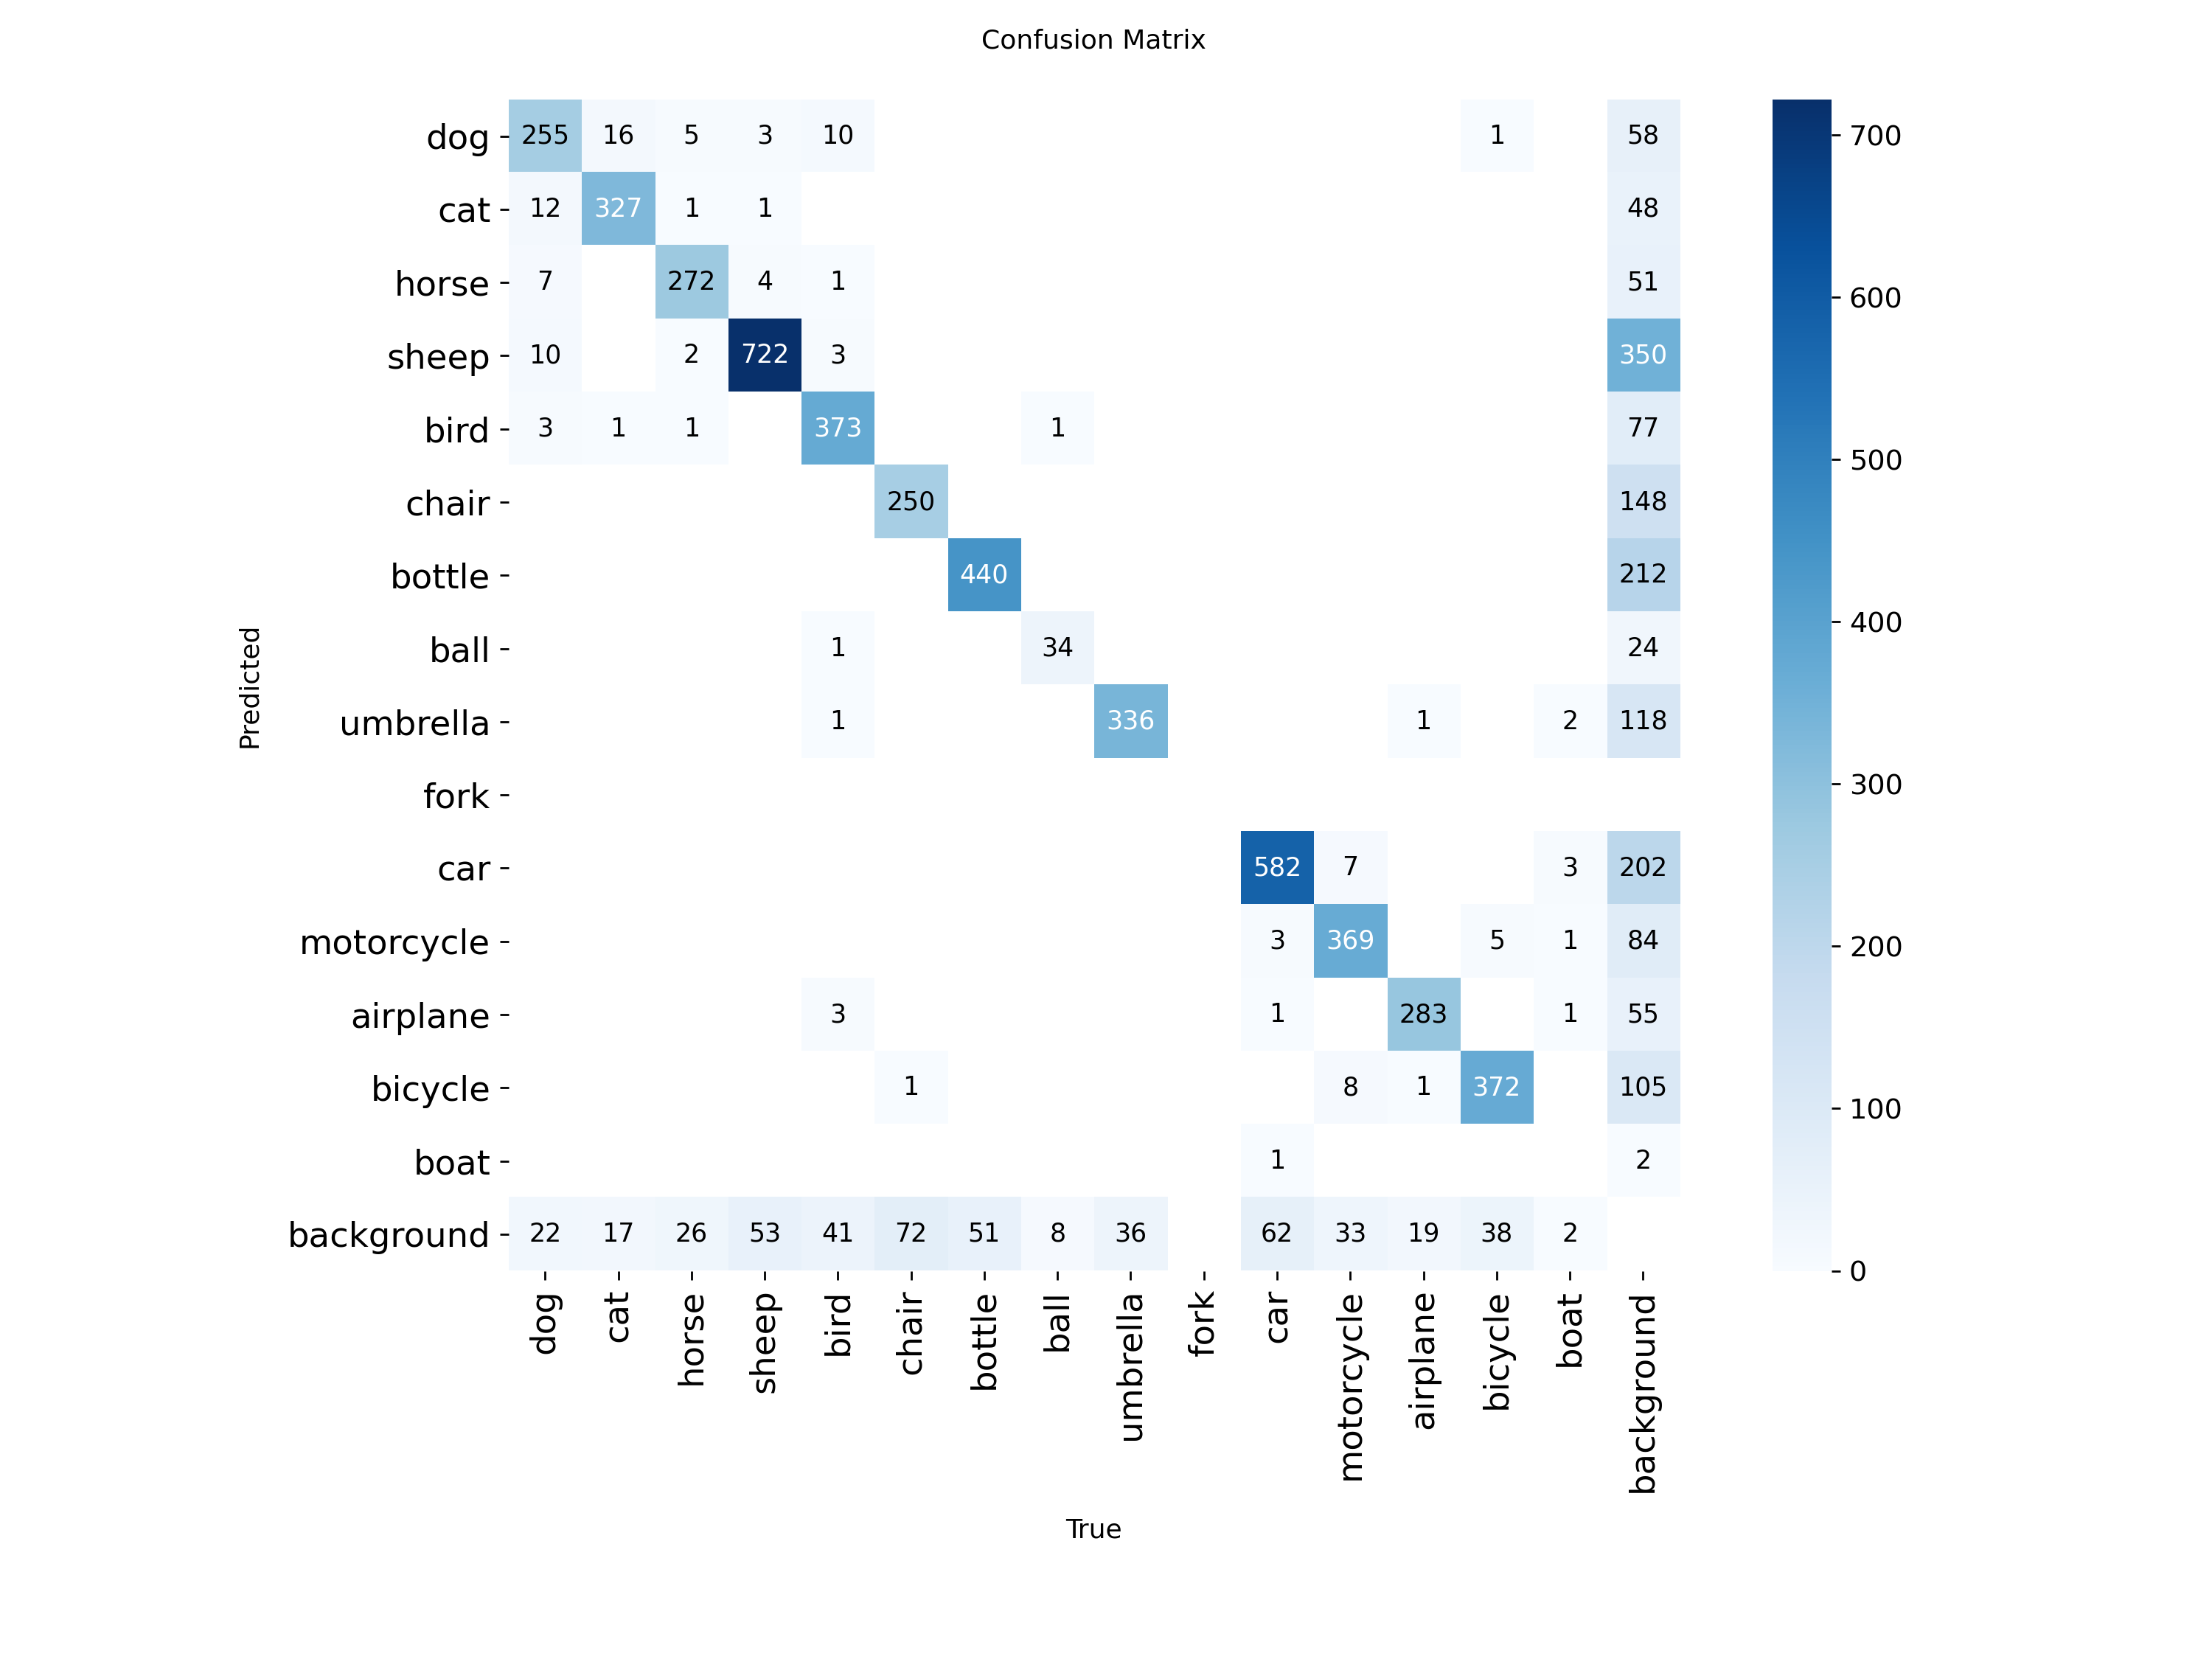

In [31]:
from IPython.display import Image, display

print("Dossier du run :", finetuned_dir)
!ls "{finetuned_dir}"

to_show = [
    "results.png",             # courbes de loss + mAP
    "PR_curve.png",            # Precision-Recall
    "F1_curve.png",            # F1 en fonction du seuil
    "confusion_matrix.png"     # matrice de confusion
]

for fname in to_show:
    f = finetuned_dir / fname
    if f.exists():
        print("\n==>", fname)
        display(Image(filename=str(f)))
    else:
        print(fname, "n'existe pas dans", finetuned_dir)



### Afficher les fichiers et images du run (results, PR/F1/confusion) s'ils existent.

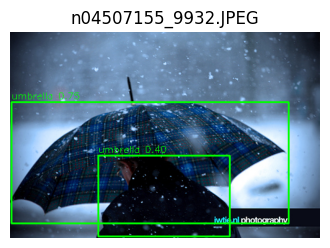

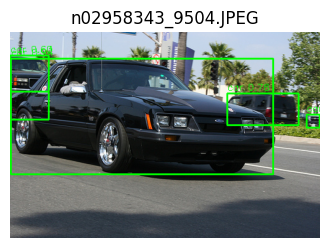

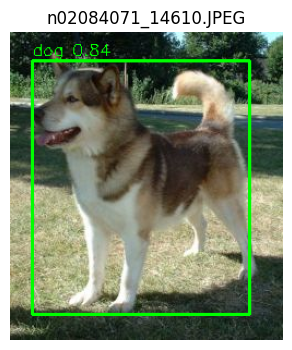

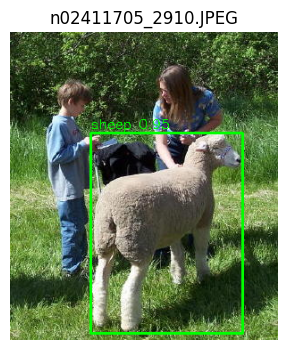

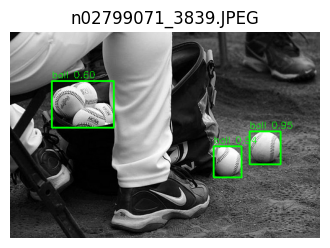

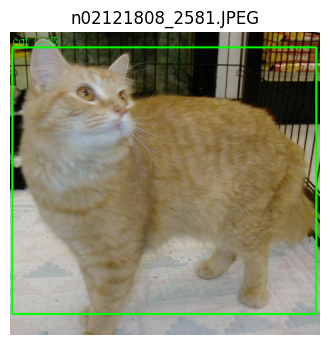

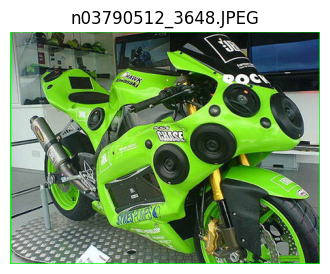

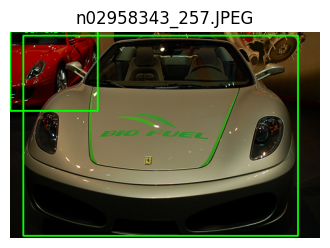

In [32]:
import cv2
import random
import matplotlib.pyplot as plt

class_names = [
    "dog","cat","horse","sheep","bird",
    "chair","bottle","ball","umbrella","fork",
    "car","motorcycle","airplane","bicycle","boat"
]

def visualize_predictions(model, img_paths, class_names, conf=0.4, device="cpu"):
    for img_path in img_paths:
        img = cv2.imread(str(img_path))
        results = model(img, conf=conf, device=device, verbose=False)[0]

        img_vis = img.copy()
        for box in results.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
            cid = int(box.cls[0])
            score = float(box.conf[0])

            if cid < 0 or cid >= len(class_names):
                continue

            label = f"{class_names[cid]} {score:.2f}"
            cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(img_vis, label, (x1, max(0,y1-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

        plt.figure(figsize=(4,4))
        plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(img_path.name)
        plt.show()

# Prendre quelques images de validation au hasard
val_imgs = list((YOLO_DATASET / "images" / "val").glob("*.*"))
sample_val_imgs = random.sample(val_imgs, min(8, len(val_imgs)))

device_pred = 0 if torch.cuda.is_available() else "cpu"
visualize_predictions(model_ft, sample_val_imgs, class_names, conf=0.4, device=device_pred)



### Définir une version de `visualize_predictions` qui supporte le paramètre `device` et afficher plusieurs images de validation.

Image test robustesse : n02924116_6498.JPEG


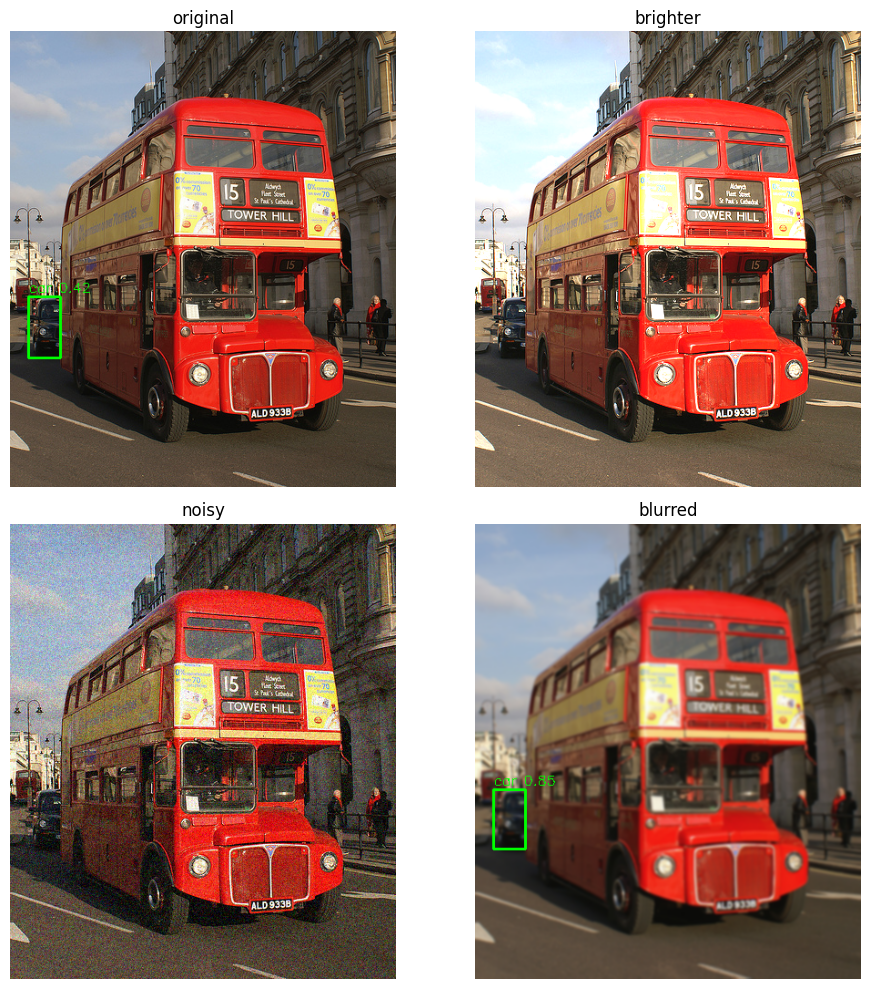

Image test robustesse : n01503061_11450.JPEG


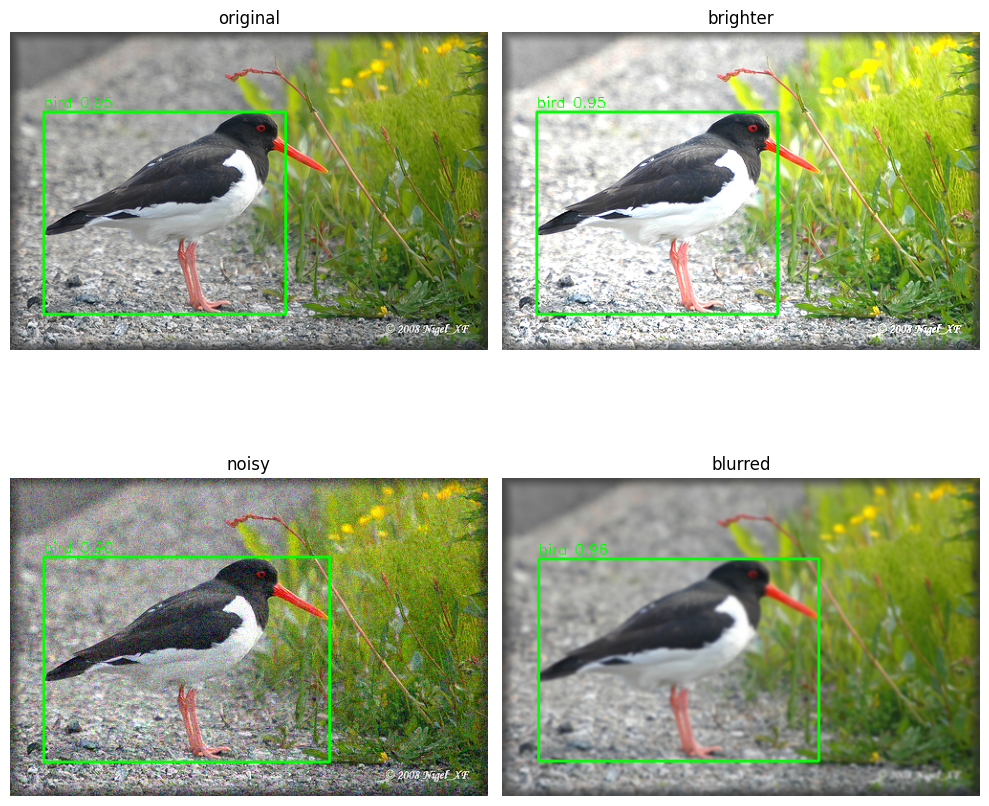

Image test robustesse : n02084071_14030.JPEG


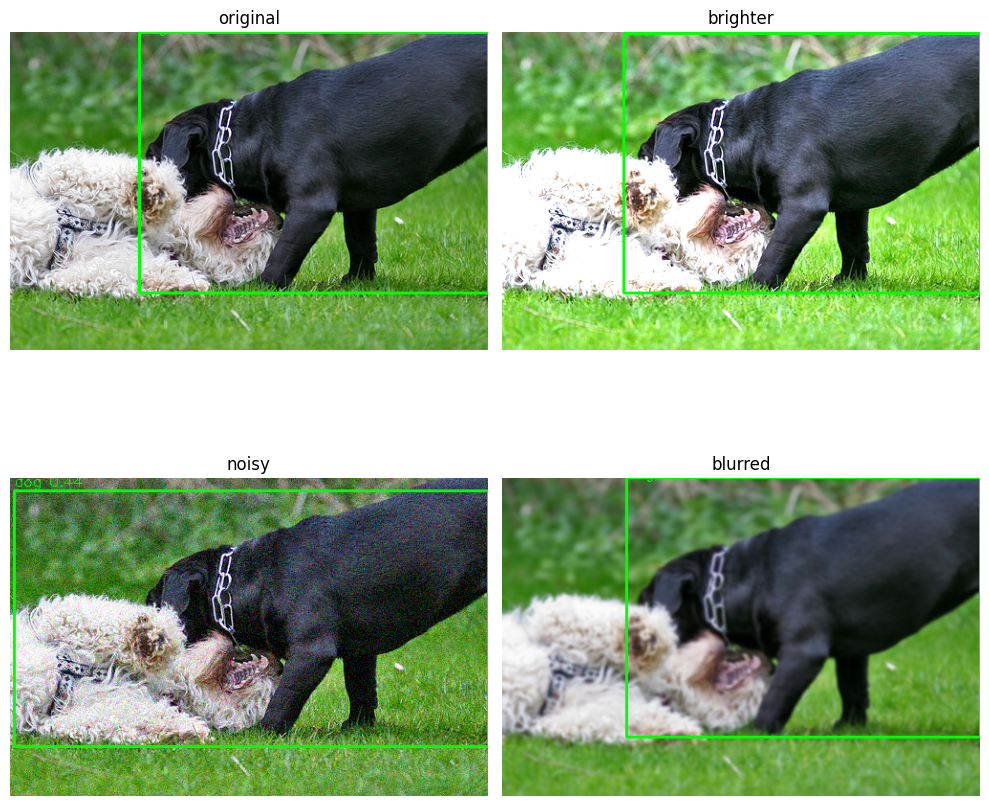

In [33]:
import numpy as np

def add_gaussian_noise(img, sigma=20):
    noise = np.random.normal(0, sigma, img.shape).astype(np.float32)
    noisy = img.astype(np.float32) + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

def change_brightness(img, factor=1.4):
    img_float = img.astype(np.float32) * factor
    return np.clip(img_float, 0, 255).astype(np.uint8)

def add_blur(img, ksize=7):
    return cv2.GaussianBlur(img, (ksize, ksize), 0)

def test_robustness_on_image(model, img_path, device="cpu", conf=0.4):
    img = cv2.imread(str(img_path))

    variants = {
        "original": img,
        "brighter": change_brightness(img, 1.4),
        "noisy": add_gaussian_noise(img, 20),
        "blurred": add_blur(img, 7),
    }

    plt.figure(figsize=(10,10))
    i = 1
    for name, im in variants.items():
        results = model(im, conf=conf, device=device, verbose=False)[0]
        im_vis = im.copy()
        for box in results.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
            cid = int(box.cls[0])
            score = float(box.conf[0])
            label = f"{class_names[cid]} {score:.2f}"
            cv2.rectangle(im_vis, (x1,y1), (x2,y2), (0,255,0), 2)
            cv2.putText(im_vis, label, (x1, max(0,y1-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

        plt.subplot(2,2,i)
        plt.imshow(cv2.cvtColor(im_vis, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(name)
        i += 1
    plt.tight_layout()
    plt.show()

# Tester sur quelques images
sample_for_robust = random.sample(val_imgs, min(3, len(val_imgs)))
device_pred = 0 if torch.cuda.is_available() else "cpu"

for p in sample_for_robust:
    print("Image test robustesse :", p.name)
    test_robustness_on_image(model_ft, p, device=device_pred, conf=0.4)
